# use VAE to generate word embedding

the input sample is the PMI signature of the word

## 1. Imports and Helper Functions

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import scipy.spatial.distance as dist
import scipy.stats as stats
from functools import reduce
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import nltk
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
%matplotlib inline
slim=tf.contrib.slim
Normal = tf.contrib.distributions.Normal
Bernoulli = tf.contrib.distributions.Bernoulli

In [2]:
def sample_gumbel(shape, eps=1e-20): 
  """Sample from Gumbel(0, 1)"""
  U = tf.random_uniform(shape,minval=0,maxval=1)
  return -tf.log(-tf.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature): 
  """ Draw a sample from the Gumbel-Softmax distribution"""
  y = logits + sample_gumbel(tf.shape(logits))
  return tf.nn.softmax( y / temperature)

def gumbel_softmax(logits, temperature, hard=False):
  """Sample from the Gumbel-Softmax distribution and optionally discretize.
  Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
  Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
  """
  y = gumbel_softmax_sample(logits, temperature)
  if hard:
    k = tf.shape(logits)[-1]
    #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
    y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keep_dims=True)),y.dtype)
    y = tf.stop_gradient(y_hard - y) + y
  return y

In [3]:
class Vocab(object):
    def __init__(self):
        self.BOS = '<s>'
        self.EOS = '</s>'
        self.UNK = '<unk>'
        self.ngram = [1]

    def build_from_files(self, train_files, test_files=[]):
        if type(train_files) is not list or type(test_files) is not list:
            raise ValueError('build_from_files input type error')

        print("build vocabulary from files ...")
        self.word_cnt = {self.EOS: 0, self.UNK: 0}
        self.char_cnt = {self.EOS: 0, self.UNK: 0}
        self.word_size = 1
        self.train_word = set()
        for _tag, _file in list(map(lambda f: ('train', f), train_files)) + list(map(lambda f: ('test', f), test_files)):
            line_num = 0
            for line in open(_file):
                line_num += 1
                for w in line.strip().split():
                    if _tag == 'train':
                        self.train_word.add(w)
                    if w in self.word_cnt:
                        self.word_cnt[w] += 1
                    else:
                        self.word_cnt[w] = 1
                    if w == self.UNK:
                        self.char_cnt[w] += 1
                    else:
                        self.word_size = max(self.word_size, len(w))
                        for c in list(w):
                            if c not in self.char_cnt:
                                self.char_cnt[c] = 1
                            else:
                                self.char_cnt[c] += 1
            if line_num > 0 and _tag == 'train':
                self.train_word.add(self.EOS)
            self.word_cnt[self.EOS] += line_num
            self.char_cnt[self.EOS] += line_num
        word_count_pairs = sorted(self.word_cnt.items(), key=lambda x: (-x[1], x[0]))
        self.words, _ = list(zip(*word_count_pairs))
        char_count_pairs = sorted(self.char_cnt.items(), key=lambda x: (-x[1], x[0]))
        self.chars, _ = list(zip(*char_count_pairs))

        self.word2id = dict(zip(self.words, range(len(self.words))))
        self.char2id = dict(zip(self.chars, range(len(self.chars))))
        self.UNK_ID = self.word2id[self.UNK]
        print('vocab size: {}, train vocab size: {}, OOV size: {}'.format(
            self.size(), len(self.train_word), self.size() - len(self.train_word)))
        print('char size: {} with max length {}'.format(self.char_size(), self.word_size))

        self.pre_emb = self.build_pre_emb(ngram=self.ngram)
        print('pre emb size with ngram {}: {}'.format(self.ngram, self.pre_emb.shape[1]))

    def build_pre_emb(self, ngram=[3]):
        def split_by_ngram(w, valid=None, ngram=[3]):
            sens = []
            for ng in ngram:
                if w == self.BOS or w == self.EOS:
                    return '#END_NGRAM'
                if w == self.UNK:
                    return '#UNKNOWN_NGRAM'
                ws = list('#' + w + '#')
                sen = ' '.join([''.join(ws[i:i+ng]) if not valid or ''.join(ws[i:i+ng]) in valid else '#UNKNOWN_NGRAM'
                                for i in range(max(len(ws) - ng + 1, 1))])
                sens.append(sen)
            return ' '.join(sens)
        valid_ngram = [split_by_ngram(w, ngram=ngram) for w in self.train_word]
        valid_ngram = reduce(lambda t,x: t | set(x.split()), valid_ngram, set())
        ngram = [split_by_ngram(w, valid=valid_ngram, ngram=ngram) for w in self.words]
        vectorizer = CountVectorizer(min_df=1, binary=True, token_pattern=r'\b[\S]+\b')
        return vectorizer.fit_transform(ngram).toarray().astype(np.float32)

    def encode(self, sentence):
        if type(sentence) is not list:
            w = sentence
            return self.word2id[w] if w in self.word2id else self.UNK_ID
        return [self.word2id[w] if w in self.word2id else self.UNK_ID for w in sentence]

    def decode(self, ids):
        if type(ids) is not list:
            _id = ids
            return self.words[_id]
        return [self.words[_id] for _id in ids]

    def encode_word(self, word):
        result = [0] * self.word_size
        if word == self.UNK or word == self.EOS:
            result[0] = self.char2id[word]
            length = 1
        else:
            length = len(word)
            for i in range(length):
                result[i] = self.char2id[word[i]] \
                    if word[i] in self.char2id else self.char2id[self.UNK]
        return result, length

    def decode_word(self, ids):
        return ''.join([self.chars[_id] for _id in ids])

    def size(self):
        return len(self.words)

    def char_size(self):
        return len(self.chars)

    def word2id(self):
        return self.word2id

## 2. Load Data

In [4]:
text_file = '../WER/ptb_data/train.txt'
#text_file = '../Tensorflow-101/notebooks/data/text8_50000'
wordsim_file = '../wordsim353_sim_rel/wordsim_similarity_goldstandard.txt'

In [5]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords += ['<unk>', '</s>', 'mr.', "'s", 'N']
stopwords = set(stopwords)

In [6]:
vocab = Vocab()
vocab.build_from_files(train_files=[text_file])

build vocabulary from files ...
vocab size: 10000, train vocab size: 10000, OOV size: 0
char size: 48 with max length 19
pre emb size with ngram [1]: 38


In [7]:
def load_wordsim(filename, vocab=None):
    r = []
    with open(filename, 'r') as fp:
        for l in fp:
            w1, w2, s = l.split()
            if vocab != None and w1 in vocab and w2 in vocab:
                r.append((w1, w2, float(s)))
    return sorted(r, key=lambda x:-x[2])

In [8]:
wordsim = load_wordsim(wordsim_file, vocab=vocab.word2id)
print('test wordsim pair count: %d' % len(wordsim))

test wordsim pair count: 131


In [9]:
def get_real_pmi(real_co_count, rescale=False):
    bigram_dict = {}
    unigram_dict = {}
    total_N = 0
    for bi, bi_count in real_co_count:
        bi_count = math.sqrt(bi_count) if rescale else bi_count
        if bi in bigram_dict:
            bigram_dict[bi] += bi_count
        elif (bi[1], bi[0]) in bigram_dict:
            bigram_dict[(bi[1], bi[0])] += bi_count
        else:
            bigram_dict[bi] = bi_count
        if bi[0] not in unigram_dict:
            unigram_dict[bi[0]] = 0
        if bi[1] not in unigram_dict:
            unigram_dict[bi[1]] = 0
        unigram_dict[bi[0]] += bi_count
        unigram_dict[bi[1]] += bi_count
        total_N += 2 * bi_count       
    pmi = [(bi, math.log(bi_count * total_N / (unigram_dict[bi[0]] * unigram_dict[bi[1]])))
           for bi,bi_count in bigram_dict.items()]
    co_count = [(bi, bi_count) for bi,bi_count in bigram_dict.items()]
    return pmi, co_count
def pmi_from_text(text_file, vocab, stopwords={}, min_count=5, window_size=5, real=True, rescale=False):
    docs = []
    with open(text_file, 'r') as fp:
        for line in fp:
            sen = line.strip().split() + [vocab.EOS]
            #sen2id = vocab.encode(sen)
            docs.append([w for w in sen if w not in stopwords])
    finder = BigramCollocationFinder.from_words(
        BigramCollocationFinder._build_new_documents(
            docs, window_size, pad_right=True), window_size=window_size)
    print('build finder over')
    finder.apply_freq_filter(min_count)
    bigram_measures = BigramAssocMeasures()
    pmi = finder.score_ngrams(bigram_measures.pmi)
    print('finder score standard pmi')
    co_count = finder.score_ngrams(lambda a,b,c: a)
    print('finder score fake cocount')
    real_co_count = finder.score_ngrams(lambda a,b,c: a * (window_size - 1))
    print('finder score real cocount')
    real_pmi, real_co_count = get_real_pmi(real_co_count, rescale=rescale)
    if real:
        return real_pmi, real_co_count, finder
    return pmi, co_count, finder
def build_pmi_matrix(pmi, vocab, binary=False, 
                     weighted_matrix_factorization=False,
                     negative_sample=1):
    row = [vocab.encode(it[0][0]) for it in pmi]
    col = [vocab.encode(it[0][1]) for it in pmi]
    data = [((math.exp(it[1]) / (math.exp(it[1]) + negative_sample))
             if weighted_matrix_factorization else 1.0)
            if binary else it[1] for it in pmi]
    nrow = row + col
    ncol = col + row
    ndata = data + data
    unrow, uncol, undata = [], [], []
    uni = set()
    for i in range(len(nrow)):
        if (nrow[i], ncol[i]) not in uni:
            uni.add((nrow[i], ncol[i]))
            unrow.append(nrow[i])
            uncol.append(ncol[i])
            undata.append(ndata[i])  
    #aa, bb = list(zip(*(list(set(list(zip(nrow, ncol)))))))
    #nrow, ncol, ndata = list(zip(*(list(set(list(zip(nrow, ncol, ndata)))))))
    matrix = csr_matrix((undata, (unrow, uncol)), 
                        shape=(vocab.size(), vocab.size()))
    return matrix

In [10]:
BINARY = True
N_COMPONENTS = 100
USE_SVD = False
WMF = True
NS = 100

In [11]:
pmi, co_count, finder = pmi_from_text(text_file, vocab, stopwords={}, 
                    min_count=1, window_size=3, real=True, rescale=False)
print('build pmi over')
matrix = build_pmi_matrix(pmi, vocab, binary=BINARY,
                          weighted_matrix_factorization=WMF, negative_sample=NS)
co_matrix = build_pmi_matrix(co_count, vocab, binary=False,
                            weighted_matrix_factorization=False)

build finder over
finder score standard pmi
finder score fake cocount
finder score real cocount
build pmi over


In [12]:
co_matrix_sum = np.array(co_matrix.sum(axis=1)).flatten()
matrix_sum = np.array(matrix.sum(axis=1)).flatten()
for mat in [matrix_sum, co_matrix_sum]:
    argco = mat.argsort()
    co = np.sort(mat)
    print(sum(mat))
    print(np.sum(co[-100:]), np.sum(co[-10:]))
    print(list(zip([vocab.decode(wid) for wid in argco], argco, co))[-100:])

180455.466255
9738.12539231 1302.67891893
[('new', 35, 77.205754861028055), ('one', 54, 77.604341600988775), ('this', 39, 78.096638534852246), ('about', 43, 78.202632287867317), ('former', 337, 78.316347987483979), ('being', 213, 79.09129734949488), ('my', 406, 79.572807685344372), ('it', 14, 79.963383528950331), ('many', 97, 79.99502167985537), ('still', 147, 80.117288423852983), ('both', 179, 80.176968181540843), ('even', 113, 80.190228327644348), ('now', 99, 80.193027511967557), ('president', 70, 80.252351928834798), ('called', 340, 80.405242893756878), ('where', 251, 80.503829887169232), ('during', 198, 80.794330329530538), ('d.', 673, 81.294787822898272), ('or', 36, 81.41617001636493), ('another', 204, 81.831031691063814), ('under', 124, 82.617460810956686), ('those', 150, 82.723605014120338), ('no', 102, 82.99983930382713), ('them', 127, 83.931881112811908), ('between', 178, 84.120017342341626), ('among', 211, 84.961845278420014), ('out', 84, 85.434385455667453), ('whose', 624, 8

In [13]:
svd = TruncatedSVD(n_components=N_COMPONENTS)
matrix_svd = svd.fit_transform(matrix)

## 3. Build Model

In [14]:
tf.reset_default_graph()

model 1: PMI VAE

In [15]:
K=100 # number of classes
N=2 # number of categorical distributions

In [16]:
# input word x (shape=(batch_size, vocab size))
x = tf.placeholder(tf.float32, [None, vocab.size()], name='word_pmi')
x_ind = tf.placeholder(tf.int32, [None], name='word_index')
x_ind_valid = tf.placeholder(tf.int32, [None], name='word_index_valid')
x_svd = tf.placeholder(tf.float32, [None, N_COMPONENTS], name='word_svd_signature')
x_weight = tf.placeholder(tf.float32, [None, vocab.size()], name='word_pmi_denominator')
# variational posterior (encoder)
#if USE_SVD:
#    net = slim.stack(x_svd, slim.fully_connected, [256])
#else:
#    net = slim.stack(x, slim.fully_connected, [256])
# unnormalized logits for N separate K-categorical distributions (shape=(batch_size*N,K))
logit_emb = tf.get_variable('logit_emb', [vocab.size(), N*K], initializer=tf.random_uniform_initializer(-.1, .1))
# normalize emb
logit_emb_norm = tf.sqrt(tf.reduce_sum(tf.square(logit_emb), 1, keep_dims=True))
normalized_logit_emb = logit_emb / logit_emb_norm
# valid emb
valid_logit_emb = tf.nn.embedding_lookup(normalized_logit_emb, x_ind_valid)
logit_siml = tf.matmul(valid_logit_emb, normalized_logit_emb, transpose_b=True)
t_logit_emb = tf.nn.embedding_lookup(logit_emb, x_ind)
#logits_y = tf.reshape(slim.fully_connected(net, N*K, activation_fn=None), [-1, K])
logits_y = tf.reshape(t_logit_emb, [-1, K])
q_y = tf.nn.softmax(logits_y)
log_q_y = tf.log(q_y+1e-20)
# temperature
tau = tf.Variable(5.0, name='temperature', trainable=False)
# sample and reshape back (shape=(batch_size,N,K))
# set hard=True for ST Gumbel-Softmax
y = tf.reshape(gumbel_softmax(logits_y, tau, hard=True), [-1, N, K])
# generative model (decoder)
#net = slim.stack(slim.flatten(y), slim.fully_connected, [256])
if USE_SVD and not BINARY:
    scores = slim.fully_connected(tf.reshape(y, [-1, N*K]), N_COMPONENTS, activation_fn=None)
else:
    scores = slim.fully_connected(tf.reshape(y, [-1, N*K]), vocab.size(), activation_fn=None)
# (shape=(batch_size,784))
if BINARY:
    p_x = Bernoulli(logits=scores)
else:
    p_x = Normal(mu=scores, sigma=.1)

In [17]:
# loss and train ops
kl_tmp = tf.reshape(q_y * (log_q_y - tf.log(1.0 / K)), [-1, N, K])
KL = tf.reduce_sum(kl_tmp, [1, 2])
if USE_SVD and not BINARY:
    elbo = tf.reduce_sum(p_x.log_prob(x_svd) * x_weight, 1) - KL
else:
    elbo = tf.reduce_sum(p_x.log_prob(x) * x_weight, 1) - KL

In [18]:
loss = tf.reduce_mean(-elbo)
lr = tf.constant(0.001)
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

model 2: w2v VAE

In [19]:
N_EMB = 100

In [20]:
emb = tf.get_variable('emb', [vocab.size(), N_EMB], initializer=tf.random_uniform_initializer(-.1, .1))
# normalize emb
emb_norm = tf.sqrt(tf.reduce_sum(tf.square(emb), 1, keep_dims=True))
normalized_emb = emb / emb_norm
# valid emb
valid_emb = tf.nn.embedding_lookup(normalized_emb, x_ind_valid)
siml = tf.matmul(valid_emb, normalized_emb, transpose_b=True)
temb = tf.nn.embedding_lookup(emb, x_ind)
#temb = tf.matmul(x_ind, emb)
#scores2 = tf.matmul(temb, tf.transpose(emb))
scores2 = slim.fully_connected(temb, vocab.size(), activation_fn=None)
p_x2 = Bernoulli(logits=scores2)

In [21]:
logloss = tf.reduce_sum(p_x2.log_prob(x) * x_weight, 1)
loss2 = tf.reduce_mean(-logloss)
train_op2 = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss2)

model 3: neg sample w2v VAE

In [22]:
pos_weight = tf.placeholder(tf.float32, [None, vocab.size()])
mul_prob = tf.placeholder(tf.float32, [None, vocab.size()])
word_weight = tf.placeholder(tf.float32, [None])
pos_mask = tf.not_equal(pos_weight, 0)
pos_count = tf.reduce_sum(tf.cast(pos_mask, tf.int32), axis=1)
max_pos_count = tf.reduce_max(pos_count)
batch_size = tf.shape(pos_weight)[0]
# find pos index and sample neg index
pos_ind = tf.boolean_mask(tf.reshape(tf.tile(tf.range(vocab.size()), [batch_size]), 
                                     [batch_size, vocab.size()]),  pos_mask) # [sum(pos_count)]
def myargmax(tensor):
    oh = tf.equal(tensor, tf.reduce_max(tensor, 1, keep_dims=True))
    ind = tf.boolean_mask(tf.reshape(tf.tile(tf.range(tf.shape(tensor)[1]), [tf.shape(tensor)[0]]), 
                                 [tf.shape(tensor)[0], tf.shape(tensor)[1]]), oh)
    return ind[:tf.shape(tensor)[0]]
def multinomial_by_gambel_max(logits, k, num, batch=1000):
    def sample_cond(step, num, batch, sample):
        return tf.cond(tf.equal(num % batch, 0), lambda: step < num // batch, lambda: step < (num // batch) + 1)
    def sample_body(step, num, batch, sample):
        tbn = tf.minimum((step + 1) * batch, num) - step * batch
        s = myargmax(logits + sample_gumbel([tbn, k]))
        s = tf.stop_gradient(s)
        return step + 1, num, batch, tf.concat([sample, s], axis=0)
    #return myargmax(tf.reshape(tf.tile(logits, [num]), [num, k]) + sample_gumbel([num, k]))
    _, _, _, s = tf.while_loop(sample_cond, sample_body, [tf.constant(0), num, batch, tf.constant([], dtype=tf.int32)], 
                              shape_invariants=[tf.TensorShape([]), tf.TensorShape([]), tf.TensorShape([]), tf.TensorShape([None])])
    return s
#neg_ind = tf.multinomial(tf.log(mul_prob), NS) # [BATCH_SIZE, NS]
#neg_ind = tf.cast(tf.ones((BATCH_SIZE, NS)), tf.int32)
neg_ind = tf.reshape(multinomial_by_gambel_max(tf.log(mul_prob[0]), vocab.size(), batch_size * NS), [batch_size, NS])
# weight bias
cla_w = tf.get_variable('classify_w', [vocab.size(), N_EMB])
cla_b = tf.get_variable('classify_bias', [vocab.size()])
# neg
neg_logits = tf.squeeze(tf.matmul(tf.nn.embedding_lookup(cla_w, neg_ind), tf.expand_dims(temb, -1))) + tf.nn.embedding_lookup(cla_b, neg_ind)
# pos
postemb = tf.boolean_mask(tf.reshape(tf.tile(temb, [1, max_pos_count]), [batch_size, max_pos_count, N_EMB]), 
                        tf.range(max_pos_count) < tf.expand_dims(pos_count, -1))
postemb = tf.reshape(postemb, [-1, N_EMB])
pos_logits = tf.reduce_sum(postemb * tf.nn.embedding_lookup(cla_w, pos_ind), axis=1) + tf.nn.embedding_lookup(cla_b, pos_ind)
# log loss
p_pos = Bernoulli(logits=pos_logits)
p_neg = Bernoulli(logits=neg_logits)
allloss = tf.reduce_sum(p_pos.log_prob(1) * tf.boolean_mask(pos_weight, pos_mask)) + \
          tf.reduce_sum(tf.matmul(tf.expand_dims(word_weight, 0), p_neg.log_prob(0)))
loss3 = - allloss / tf.cast(batch_size, tf.float32)
train_op3 = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss3)

/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


model 4: low variance neg sample w2v VAE

In [23]:
def neg_sample_cond(step, sample_num, sample, unique_sample, unique_sample_count, unique_sample_num):
    return tf.shape(sample_num)[0] > 0
def neg_sample_body(step, sample_num, sample, unique_sample, unique_sample_count, unique_sample_num):
    ts = sample[:sample_num[0]]
    #ts = sample[tf.cond(tf.equal(step, 0), lambda: 0, lambda: tf.reduce_sum(sample_num[:step])):
    #            tf.reduce_sum(sample_num[:step+1])]
    us, idx = tf.unique(ts)
    #usc = tf.reduce_sum(tf.cast(tf.equal(ts, tf.expand_dims(us, -1)), tf.int32), 1)
    usc = tf.foldl(
        lambda usc, item: usc + tf.one_hot(
            item, tf.shape(us)[0], dtype=tf.int32),
        idx,
        initializer=tf.zeros_like(us, dtype=tf.int32))
    usn = tf.shape(us)    
    return step + 1, sample_num[1:], sample[sample_num[0]:], \
           tf.concat([unique_sample, us], axis=0), tf.concat([unique_sample_count, usc], axis=0), \
           tf.concat([unique_sample_num, usn], axis=0)
ns_frac = tf.constant(100.)
neg_sample_num = tf.cast(word_weight * NS / ns_frac, tf.int32)
neg_sample = multinomial_by_gambel_max(tf.log(mul_prob[0]), vocab.size(), tf.reduce_sum(neg_sample_num))
_, _, _, neg_unique_sample, neg_unique_sample_count, neg_unique_sample_num = \
    tf.while_loop(neg_sample_cond, neg_sample_body, [tf.constant(0), neg_sample_num, neg_sample, 
                                                     tf.constant([], dtype=tf.int32),
                                                     tf.constant([], dtype=tf.int32),
                                                     tf.constant([], dtype=tf.int32)],
                 shape_invariants=[tf.TensorShape([]), tf.TensorShape([None]), tf.TensorShape([None]), 
                                   tf.TensorShape([None]), tf.TensorShape([None]), tf.TensorShape([None])])
def neg_logits_cond(step, neg_unique_sample_num, neg_unique_sample, temb, neg_logits):
    return tf.shape(neg_unique_sample_num)[0] > 0
def neg_logits_body(step, neg_unique_sample_num, neg_unique_sample, temb, neg_logits):
    tus = neg_unique_sample[:neg_unique_sample_num[0]]
    lo = tf.reduce_sum(tf.nn.embedding_lookup(cla_w, tus) * temb[0], axis=1) + \
         tf.nn.embedding_lookup(cla_b, tus)
    return step + 1, neg_unique_sample_num[1:], neg_unique_sample[neg_unique_sample_num[0]:], \
           temb[1:], tf.concat([neg_logits, lo], axis=0)
_, _, _, _, neg_sample_logits = tf.while_loop(neg_logits_cond, neg_logits_body, 
                                  [tf.constant(0), neg_unique_sample_num, neg_unique_sample,
                                  temb, tf.constant([], dtype=tf.float32)],
                                 shape_invariants=[tf.TensorShape([]), tf.TensorShape([None]), tf.TensorShape([None]),
                                                  tf.TensorShape([None, N_EMB]), tf.TensorShape([None])])
#max_neg_count = tf.reduce_max(neg_unique_sample_num)
#negtemb = tf.boolean_mask(tf.reshape(tf.tile(temb, [1, max_neg_count]), [batch_size, max_neg_count, N_EMB]),
#                         tf.range(max_neg_count) < tf.expand_dims(neg_unique_sample_num, -1))
#negtemb = tf.reshape(negtemb, [-1, N_EMB])
#neg_sample_logits = tf.reduce_sum(negtemb * tf.nn.embedding_lookup(cla_w, neg_unique_sample), axis=1) + \
#                    tf.nn.embedding_lookup(cla_b, neg_unique_sample)
p_neg_sample = Bernoulli(logits=neg_sample_logits)
allloss2 = tf.reduce_sum(p_pos.log_prob(1) * tf.boolean_mask(pos_weight, pos_mask))
allloss2 = allloss2 + tf.reduce_sum(p_neg_sample.log_prob(0) * tf.cast(neg_unique_sample_count, tf.float32)) * ns_frac
loss4 = - allloss2 / tf.cast(batch_size, tf.float32)
train_op4 = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss4)
init_op = tf.global_variables_initializer()

/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## 4. Train

In [24]:
USE_MODEL = 1
BATCH_SIZE = 100
NUM_ITERS = 200
tau0 = 1.0 # initial temperature
np_tau = tau0
np_lr = 0.01
NS_FRAC = 100
ANNEAL_RATE = 0.00003
MIN_TEMP = 0.1
VALID_WORDS = ['one', 'five', 'two', 'million', 'government', 'japan', 'inevitable', 'rational', 'florida', 'corn', 'facility']
VALID_WORDS = [vocab.encode(w) for w in VALID_WORDS] + np.random.permutation(vocab.size())[:10].tolist()
VALID_WORDS = list(set(VALID_WORDS))
print([vocab.decode(w) for w in VALID_WORDS])
VALID_TOPK = 5

['device', 'five', 'government', 'workings', 'completing', 'suggesting', 'two', 'japan', 'facility', 'inevitable', 'concerned', 'million', 'one', 'longer', 'roadways', 'florida', 'parent', 'limbo', 'wildlife', 'rational', 'corn']


In [25]:
dat = []
#sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess.run(init_op)
np_emb_last = None
for i in range(NUM_ITERS):
    perm = np.random.permutation(vocab.size())
    batch_num = math.ceil(vocab.size() / BATCH_SIZE)
    for b in range(batch_num):
        tb = perm[b*BATCH_SIZE:(b+1)*BATCH_SIZE]
        np_x_ind = tb
        np_x = matrix[tb].toarray()
        np_x_svd = matrix_svd[tb]
        if BINARY and WMF:
            np_x_weight = co_matrix_sum[tb].reshape(len(tb), 1) * co_matrix_sum * NS / np.sum(co_matrix_sum)
            np_x_weight /= 1 - np_x
            #print(np_x_weight[:, tb])
            #input()
        else:
            np_x_weight = np.ones_like(np_x)
        if USE_MODEL == 1:
            _, np_loss, hv = sess.run([train_op, loss, y], {
                x: np_x,
                x_ind: np_x_ind,
                x_svd: np_x_svd,
                x_weight: np_x_weight,
                tau: np_tau,
                lr: np_lr
            })
            if BINARY and WMF:  
                np_loss = np_loss * BATCH_SIZE / np.sum(np_x_weight)
            np_emb = logit_emb.eval(sess)
            if np_emb_last == None:
                np_emb_last = np_emb
            emb_change = np.sum(np.square(np_emb_last - np_emb))
            np_emb_last = np_emb
            # wordsim
            np_norm_emb = sess.run(normalized_logit_emb)
            nsims = [-dist.cosine(np_norm_emb[vocab.encode(p[0])], np_norm_emb[vocab.encode(p[1])]) 
                     for p in wordsim]
            corr = stats.spearmanr(nsims, [p[2] for p in wordsim]).correlation
            dat.append([i * batch_num + b, np_tau, np_lr, np_loss, emb_change, corr])
            #dat.append([i * batch_num + b, np_tau, np_loss])
        elif USE_MODEL == 2 or USE_MODEL == 3 or USE_MODEL == 4:
            if USE_MODEL == 2:
                _, np_loss = sess.run([train_op2, loss2], {
                    x: np_x,
                    x_ind: np_x_ind,                
                    x_weight: np_x_weight,
                    lr: np_lr
                })
                if BINARY and WMF:  
                    np_loss = np_loss * BATCH_SIZE / np.sum(np_x_weight)
            elif USE_MODEL == 3:                
                _, np_loss = sess.run([train_op3, loss3], {
                    x_ind: np_x_ind, 
                    pos_weight: co_matrix[tb].toarray(),
                    mul_prob: np.tile(co_matrix_sum, [BATCH_SIZE]).reshape(BATCH_SIZE, vocab.size()),
                    word_weight: co_matrix_sum[tb],
                    lr: np_lr
                })
                if BINARY and WMF:  
                    np_loss = np_loss * BATCH_SIZE / np.sum(np_x_weight)
            elif USE_MODEL == 4:
                _, np_loss, np_neg_unique_sample, np_neg_unique_sample_count = \
                sess.run([train_op4, loss4, neg_unique_sample, neg_unique_sample_count], {
                    x_ind: np_x_ind, 
                    pos_weight: co_matrix[tb].toarray(),
                    mul_prob: np.tile(co_matrix_sum, [BATCH_SIZE]).reshape(BATCH_SIZE, vocab.size()),
                    word_weight: co_matrix_sum[tb],
                    lr: np_lr,
                    ns_frac: NS_FRAC
                })
                if BINARY and WMF:  
                    np_loss = np_loss * BATCH_SIZE / np.sum(np_x_weight)
            # emb change
            np_emb = emb.eval(sess)
            if np_emb_last == None:
                np_emb_last = np_emb
            emb_change = np.sum(np.square(np_emb_last - np_emb))
            np_emb_last = np_emb
            # wordsim
            np_norm_emb = sess.run(normalized_emb)
            nsims = [-dist.cosine(np_norm_emb[vocab.encode(p[0])], np_norm_emb[vocab.encode(p[1])]) 
                     for p in wordsim]
            corr = stats.spearmanr(nsims, [p[2] for p in wordsim]).correlation
            dat.append([i * batch_num + b, np_tau, np_lr, np_loss, emb_change, corr])
            # model 4 neg sample track
            #print(len(np_neg_unique_sample), np.sum(co_matrix_sum[tb] != 0), np.sum(np_neg_unique_sample_count), np.sum(co_matrix_sum[tb]) * NS / NS_FRAC)
            #rsp = np.random.permutation(len(np_neg_unique_sample))[:20]
            #print(np_neg_unique_sample[rsp], np_neg_unique_sample_count[rsp])
        if (i * batch_num + b) % 1000 == 1:        
            np_tau = np.maximum(tau0*np.exp(-ANNEAL_RATE*(i * batch_num + b)), MIN_TEMP)
            np_lr *= 0.9
        if (i * batch_num + b) % 100 == 1:
            print('Step %d, ELBO: %0.3f, dEMB: %0.5f, wordsim corr: %0.5f' % (i * batch_num + b, np_loss, emb_change, corr))
        if (USE_MODEL == 2 or USE_MODEL == 3 or USE_MODEL == 4) and (i * batch_num + b) % 250 == 1:
            siml_val = sess.run(siml, {
                x_ind_valid: VALID_WORDS,
            })
            for w in range(len(VALID_WORDS)):
                valid_word = vocab.decode(VALID_WORDS[w])
                nearest = (-siml_val[w, :]).argsort()[1:VALID_TOPK+1]
                log_str = '"%s":' % valid_word
                for tk in range(VALID_TOPK):
                    close_word = vocab.decode(nearest[tk])
                    log_str = '%s "%s",' % (log_str, close_word)
                print(log_str)
        if (USE_MODEL == 1) and (i * batch_num + b) % 250 == 1:
            siml_val = sess.run(logit_siml, {
                x_ind_valid: VALID_WORDS,
            })
            for w in range(len(VALID_WORDS)):
                valid_word = vocab.decode(VALID_WORDS[w])
                nearest = (-siml_val[w, :]).argsort()[1:VALID_TOPK+1]
                log_str = '"%s":' % valid_word
                for tk in range(VALID_TOPK):
                    close_word = vocab.decode(nearest[tk])
                    log_str = '%s "%s",' % (log_str, close_word)
                print(log_str)

/home/zhuyutao/lightrnn/env_python3.4/lib/python3.4/site-packages/ipykernel_launcher.py:33: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Step 1, ELBO: 0.682, dEMB: 1.95321, wordsim corr: 0.17855
"device": "evasion", "bottled", "bankruptcy-law", "prepared", "cost-cutting",
"five": "imposing", "advocates", "dorfman", "opera", "attack",
"government": "foundations", "khan", "vigorously", "team", "unlikely",
"workings": "shoulder", "specializing", "inaccurate", "paintings", "views",
"completing": "commentary", "southwestern", "chiefs", "dozen", "disaster",
"suggesting": "warehouses", "things", "interests", "cathcart", "operated",
"two": "champagne", "u.s.s.r.", "cruise", "ratners", "ownership",
"japan": "artery", "postpone", "field", "manager", "incompetent",
"facility": "equitable", "rocky", "usx", "bruce", "barriers",
"inevitable": "instruction", "salmonella", "mrs.", "railroad", "surveys",
"concerned": "debate", "russell", "risc", "tiny", "capitalists",
"million": "louis", "angels", "zealand", "estimates", "succeed",
"one": "freeport-mcmoran", "co-chief", "upgrading", "trials", "alternatives",
"longer": "concentrate", "ha

Step 1301, ELBO: 0.058, dEMB: 1.45307, wordsim corr: 0.23899
Step 1401, ELBO: 0.057, dEMB: 1.47762, wordsim corr: 0.25018
Step 1501, ELBO: 0.058, dEMB: 1.36506, wordsim corr: 0.26603
"device": "motel", "amr", "pot", "exhibition", "cast",
"five": "northeast", "bonds", "front", "personal-injury", "zip",
"government": "dangerous", "trademark", "electrical", "effect", "insurer",
"workings": "reinforced", "flamboyant", "completing", "dismal", "zip",
"completing": "supporters", "theater", "wondering", "ernest", "rehabilitation",
"suggesting": "schroder", "meets", "olympic", "bass", "gaining",
"two": "ted", "unified", "1960s", "creditor", "elegant",
"japan": "vested", "lifting", "welch", "distributes", "accident",
"facility": "seat", "thrift", "mather", "coaches", "benson",
"inevitable": "bonds", "cohen", "overhead", "parallel", "deflator",
"concerned": "season", "cat", "visiting", "happy", "lighting",
"million": "redeem", "telling", "repeated", "brands", "calgary",
"one": "union", "pricings"

Step 2801, ELBO: 0.056, dEMB: 1.00637, wordsim corr: 0.19728
Step 2901, ELBO: 0.054, dEMB: 1.01081, wordsim corr: 0.21422
Step 3001, ELBO: 0.056, dEMB: 1.02909, wordsim corr: 0.23031
"device": "pot", "wondering", "burlington", "dapuzzo", "forces",
"five": "peladeau", "microprocessor", "door", "sweden", "sagging",
"government": "insurer", "prevented", "rehabilitation", "research", "effect",
"workings": "reinforced", "recovering", "rallies", "completing", "clerk",
"completing": "divergence", "permit", "unocal", "actually", "wondering",
"suggesting": "cup", "face-to-face", "chemical", "middlemen", "battered",
"two": "ethical", "surging", "exciting", "lawn", "1960s",
"japan": "upper", "louis", "error", "lengthy", "cigna",
"facility": "complain", "presentation", "machinists", "hyman", "downgrade",
"inevitable": "rule", "wine", "harsh", "cohen", "upward",
"concerned": "season", "contends", "malignant", "returning", "happy",
"million": "redeem", "trillion", "hk$", "billion", "earned",
"one": 

Step 4301, ELBO: 0.056, dEMB: 0.82666, wordsim corr: 0.15742
Step 4401, ELBO: 0.056, dEMB: 0.82857, wordsim corr: 0.15860
Step 4501, ELBO: 0.056, dEMB: 0.79580, wordsim corr: 0.16875
"device": "politics", "empire", "media", "proposed", "defaults",
"five": "years", "jaguar", "bonds", "yields", "protection",
"government": "deep", "insurer", "again", "whatever", "plant",
"workings": "reinforced", "contested", "yorker", "voter", "simultaneous",
"completing": "marked", "bargaining", "array", "judicial", "domestically",
"suggesting": "sounds", "standards", "say", "battered", "rough",
"two": "gradual", "exclusively", "defaults", "amoco", "split",
"japan": "error", "upper", "magazine", "medium-sized", "flag",
"facility": "guarantee", "whole", "water", "charges", "tradition",
"inevitable": "wines", "clearly", "cautiously", "author", "curbs",
"concerned": "worry", "contends", "season", "happy", "debts",
"million": "redeem", "billion", "300-a-share", "trillion", "apiece",
"one": "medium-sized", "

Step 5801, ELBO: 0.056, dEMB: 0.78025, wordsim corr: 0.12435
Step 5901, ELBO: 0.056, dEMB: 0.78489, wordsim corr: 0.12681
Step 6001, ELBO: 0.056, dEMB: 0.84085, wordsim corr: 0.13110
"device": "empire", "defined", "media", "car", "wang",
"five": "april", "each", "estimated", "years", "decline",
"government": "research", "bulk", "plant", "ran", "car",
"workings": "dusty", "domination", "postwar", "federation", "indonesia",
"completing": "weakened", "bumiputra", "consumer", "overall", "asset-backed",
"suggesting": "say", "shape", "sounds", "names", "conceded",
"two": "marked", "prison", "amoco", "dumped", "detectors",
"japan": "error", "upper", "alberta", "avery", "medium-sized",
"facility": "whole", "eye", "guarantee", "disaster", "integrity",
"inevitable": "cautiously", "clearly", "ridiculous", "modernization", "vulnerable",
"concerned": "worry", "waiting", "deal", "approach", "useful",
"million": "billion", "trillion", "redeem", "apiece", "earned",
"one": "mushrooms", "some", "plenty"

Step 7301, ELBO: 0.056, dEMB: 0.66654, wordsim corr: 0.12132
Step 7401, ELBO: 0.056, dEMB: 0.66934, wordsim corr: 0.11798
Step 7501, ELBO: 0.055, dEMB: 0.67378, wordsim corr: 0.12870
"device": "empire", "aim", "viewed", "fear", "characters",
"five": "volume", "seven", "years", "april", "each",
"government": "bulk", "car", "team", "plant", "empire",
"workings": "domination", "postwar", "contested", "parallel", "continent",
"completing": "overall", "prohibits", "miners", "arteries", "consumer",
"suggesting": "insist", "say", "arguing", "conceded", "conservatives",
"two": "recent", "quarters", "prison", "distribution", "segments",
"japan": "error", "production", "alberta", "office", "ad",
"facility": "text", "responsibilities", "iron", "subsidiaries", "disaster",
"inevitable": "plagued", "firmly", "insisting", "commenting", "marketers",
"concerned": "worry", "happening", "guys", "fast", "waiting",
"million": "billion", "trillion", "redeem", "apiece", "N",
"one": "aimed", "enthusiasm", "pl

Step 8801, ELBO: 0.056, dEMB: 0.61747, wordsim corr: 0.13862
Step 8901, ELBO: 0.056, dEMB: 0.62000, wordsim corr: 0.13212
Step 9001, ELBO: 0.056, dEMB: 0.62723, wordsim corr: 0.13667
"device": "characters", "goals", "technique", "empire", "younger",
"five": "seven", "volume", "fiscal", "years", "april",
"government": "car", "team", "bulk", "family", "guidelines",
"workings": "domination", "postwar", "dominance", "heels", "emergence",
"completing": "overall", "long-distance", "measurement", "portable", "periodic",
"suggesting": "insist", "conservatives", "say", "impression", "complained",
"two": "recent", "prison", "quarters", "few", "several",
"japan": "rally", "alberta", "addition", "canada", "production",
"facility": "iron", "responsibilities", "mills", "subsidiaries", "technologies",
"inevitable": "plagued", "commenting", "firmly", "discarded", "troubling",
"concerned": "worry", "happening", "looking", "there", "worried",
"million": "billion", "trillion", "N", "redeem", "apiece",
"o

"device": "characters", "goals", "viewed", "understanding", "problem",
"five": "seven", "fiscal", "volume", "april", "three",
"government": "car", "team", "crisis", "biggest", "bulk",
"workings": "domination", "postwar", "premises", "heels", "1930s",
"completing": "periodic", "measurement", "permissible", "analyzing", "prohibits",
"suggesting": "insist", "conservatives", "studied", "successful", "impression",
"two": "recent", "quarters", "prison", "few", "several",
"japan": "alberta", "canada", "rally", "office", "boeing",
"facility": "iron", "technologies", "tour", "floors", "beer",
"inevitable": "plagued", "name-dropping", "firmly", "discarded", "insisting",
"concerned": "worry", "looking", "there", "someone", "guys",
"million": "billion", "trillion", "N", "apiece", "rose",
"one": "aimed", "enthusiasm", "sitting", "sort", "instance",
"longer": "guys", "useful", "seen", "very", "there",
"roadways": "foam", "potatoes", "wore", "theoretical", "marketers",
"florida": "regional", "pennsyl

Step 11601, ELBO: 0.055, dEMB: 0.37208, wordsim corr: 0.12626
Step 11701, ELBO: 0.055, dEMB: 0.37856, wordsim corr: 0.12906
"device": "characters", "attitude", "goals", "technique", "understanding",
"five": "seven", "three", "april", "fiscal", "six",
"government": "car", "crisis", "constitution", "ministry", "currency",
"workings": "postwar", "domination", "premises", "emergence", "strengthening",
"completing": "periodic", "analyzing", "maintaining", "permissible", "measurement",
"suggesting": "insist", "studied", "successful", "conservatives", "sounds",
"two": "recent", "quarters", "several", "prison", "few",
"japan": "alberta", "canada", "bases", "offices", "office",
"facility": "iron", "tour", "battery", "businessman", "subsidiaries",
"inevitable": "firmly", "name-dropping", "discarded", "insisting", "plagued",
"concerned": "worry", "there", "looking", "guys", "worried",
"million": "billion", "trillion", "N", "apiece", "nov.",
"one": "aimed", "sitting", "sort", "instance", "fun",
"l

Step 13101, ELBO: 0.055, dEMB: 0.24745, wordsim corr: 0.13051
Step 13201, ELBO: 0.056, dEMB: 0.24763, wordsim corr: 0.12998
"device": "characters", "attitude", "technique", "understanding", "cowboys",
"five": "seven", "three", "six", "april", "fiscal",
"government": "car", "currency", "constitution", "team", "crisis",
"workings": "legitimacy", "postwar", "premises", "emergence", "domination",
"completing": "periodic", "posed", "maintaining", "equation", "miners",
"suggesting": "insist", "studied", "conservatives", "sounds", "opposed",
"two": "recent", "three", "few", "quarters", "several",
"japan": "offices", "canada", "alberta", "office", "top",
"facility": "iron", "tour", "battery", "businessman", "beer",
"inevitable": "firmly", "discarded", "insisting", "name-dropping", "officially",
"concerned": "worry", "there", "worried", "looking", "surprising",
"million": "billion", "trillion", "N", "apiece", "yen",
"one": "aimed", "aids", "instance", "fun", "sitting",
"longer": "useful", "guys

Step 14601, ELBO: 0.055, dEMB: 0.19415, wordsim corr: 0.12975
Step 14701, ELBO: 0.055, dEMB: 0.19805, wordsim corr: 0.13175
"device": "attitude", "technique", "characters", "mission", "notion",
"five": "seven", "three", "six", "eight", "april",
"government": "car", "currency", "constitution", "carrier", "ministry",
"workings": "legitimacy", "postwar", "emergence", "glare", "premises",
"completing": "periodic", "equation", "miners", "measurement", "smallest",
"suggesting": "insist", "studied", "sounds", "opposed", "indeed",
"two": "recent", "three", "several", "quarters", "few",
"japan": "offices", "canada", "britain", "bases", "france",
"facility": "iron", "tour", "beer", "battery", "businessman",
"inevitable": "firmly", "discarded", "flaws", "insisting", "disagreement",
"concerned": "worry", "there", "surprising", "looking", "comfortable",
"million": "billion", "trillion", "N", "yen", "apiece",
"one": "aimed", "aids", "instance", "fun", "sitting",
"longer": "useful", "very", "wonder",

Step 16101, ELBO: 0.055, dEMB: 0.12247, wordsim corr: 0.13430
Step 16201, ELBO: 0.054, dEMB: 0.12780, wordsim corr: 0.13496
"device": "technique", "characters", "mission", "attitude", "notion",
"five": "seven", "three", "six", "eight", "april",
"government": "currency", "car", "constitution", "ministry", "carrier",
"workings": "postwar", "emergence", "glare", "legitimacy", "inning",
"completing": "periodic", "equation", "miners", "blocking", "smallest",
"suggesting": "insist", "studied", "sounds", "indeed", "impression",
"two": "recent", "three", "several", "few", "quarters",
"japan": "europe", "britain", "offices", "canada", "france",
"facility": "iron", "beer", "tour", "battery", "components",
"inevitable": "commenting", "firmly", "discarded", "revealed", "scary",
"concerned": "worry", "there", "surprising", "comfortable", "agree",
"million": "billion", "trillion", "N", "yen", "apiece",
"one": "aimed", "aids", "sitting", "particular", "instance",
"longer": "very", "useful", "soon", "

Step 17601, ELBO: 0.055, dEMB: 0.09584, wordsim corr: 0.13847
Step 17701, ELBO: 0.055, dEMB: 0.09715, wordsim corr: 0.13890
"device": "technique", "characters", "mission", "belief", "attitude",
"five": "seven", "three", "six", "eight", "four",
"government": "currency", "carrier", "car", "panel", "constitution",
"workings": "emergence", "glare", "postwar", "inning", "legitimacy",
"completing": "miners", "equation", "periodic", "blocking", "simultaneous",
"suggesting": "insist", "studied", "indeed", "stressed", "sounds",
"two": "recent", "three", "several", "few", "quarters",
"japan": "europe", "britain", "offices", "france", "production",
"facility": "iron", "beer", "tour", "components", "supplier",
"inevitable": "commenting", "scary", "discarded", "firmly", "revealed",
"concerned": "worry", "surprising", "there", "comfortable", "gone",
"million": "billion", "trillion", "yen", "N", "apiece",
"one": "aimed", "sitting", "aids", "particular", "sort",
"longer": "very", "useful", "soon", "un

Step 19101, ELBO: 0.055, dEMB: 0.06325, wordsim corr: 0.13672
Step 19201, ELBO: 0.055, dEMB: 0.06246, wordsim corr: 0.13782
"device": "technique", "characters", "mission", "belief", "attitude",
"five": "seven", "three", "six", "eight", "four",
"government": "carrier", "currency", "panel", "car", "constitution",
"workings": "emergence", "inning", "glare", "postwar", "legitimacy",
"completing": "miners", "periodic", "equation", "blocking", "permissible",
"suggesting": "insist", "studied", "sounds", "stressed", "indeed",
"two": "recent", "three", "several", "few", "quarters",
"japan": "britain", "offices", "france", "canada", "europe",
"facility": "iron", "tour", "beer", "supplier", "components",
"inevitable": "scary", "commenting", "censorship", "firmly", "discarded",
"concerned": "worry", "surprising", "comfortable", "gone", "there",
"million": "billion", "trillion", "yen", "N", "apiece",
"one": "aimed", "sitting", "particular", "sort", "aids",
"longer": "very", "soon", "worry", "useful

## 5. Plot

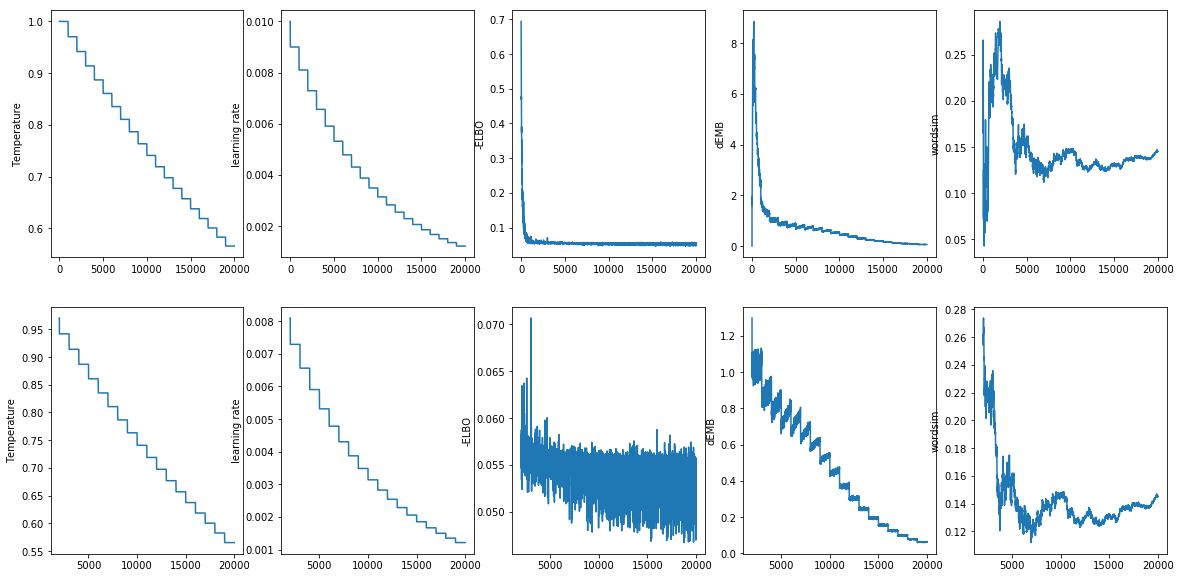

In [26]:
np_dat = np.array(dat).T
f, axarr = plt.subplots(2, (np_dat.shape[0]-1))
f.set_size_inches((20,10))
ylabels = ['Temperature', 'learning rate', '-ELBO', 'dEMB', 'wordsim']
for i in range(np_dat.shape[0] - 1):
    axarr[0][i].plot(np_dat[0], np_dat[i+1])
    axarr[0][i].set_ylabel(ylabels[i])
for i in range(np_dat.shape[0] - 1):
    axarr[1][i].plot(np_dat[0, 2000:], np_dat[i+1, 2000:])
    axarr[1][i].set_ylabel(ylabels[i])

In [27]:
np_logit_prob = sess.run(tf.reshape(tf.nn.softmax(tf.reshape(logit_emb, [-1, K])), [-1, N, K]))

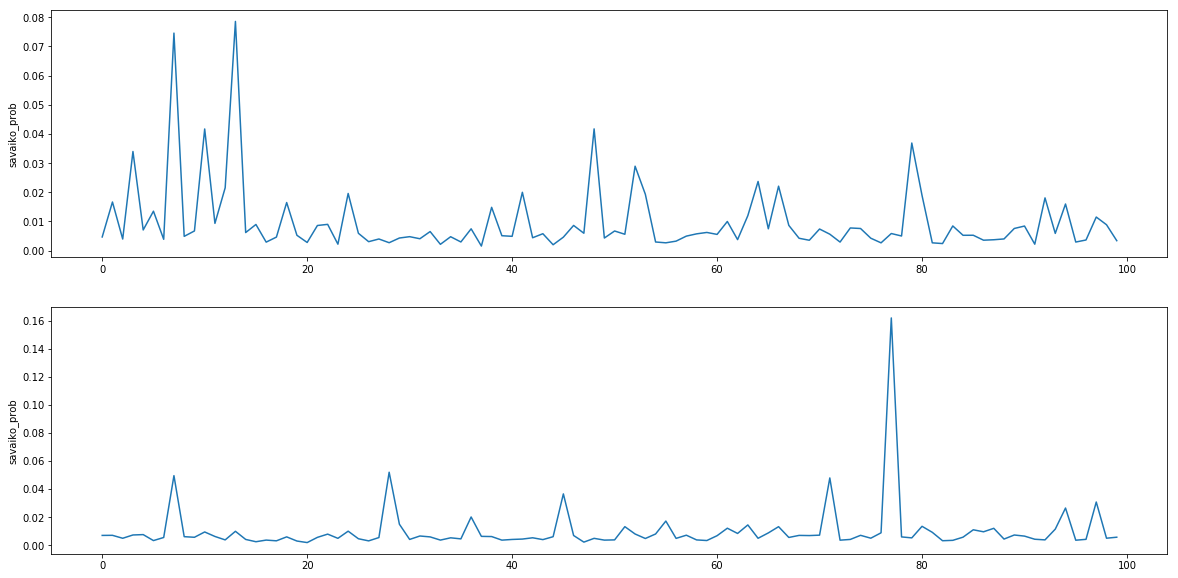

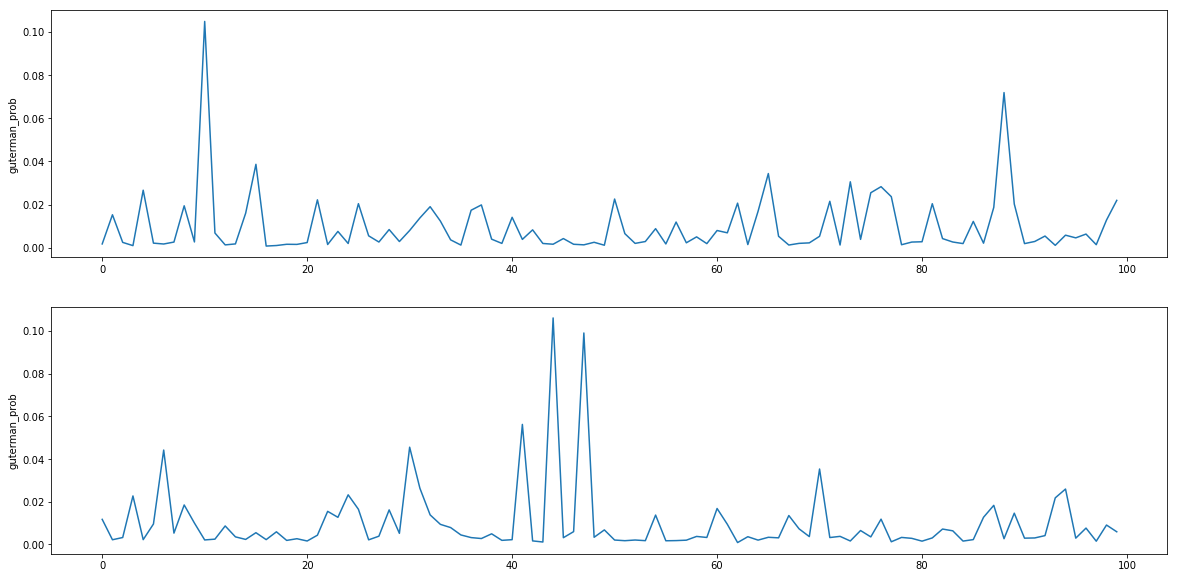

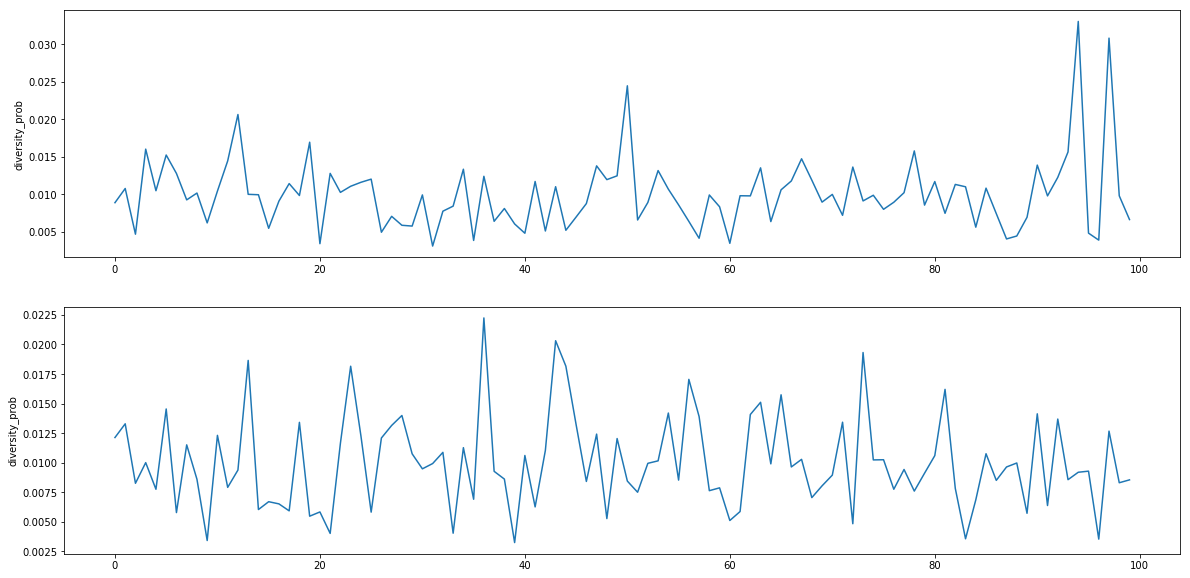

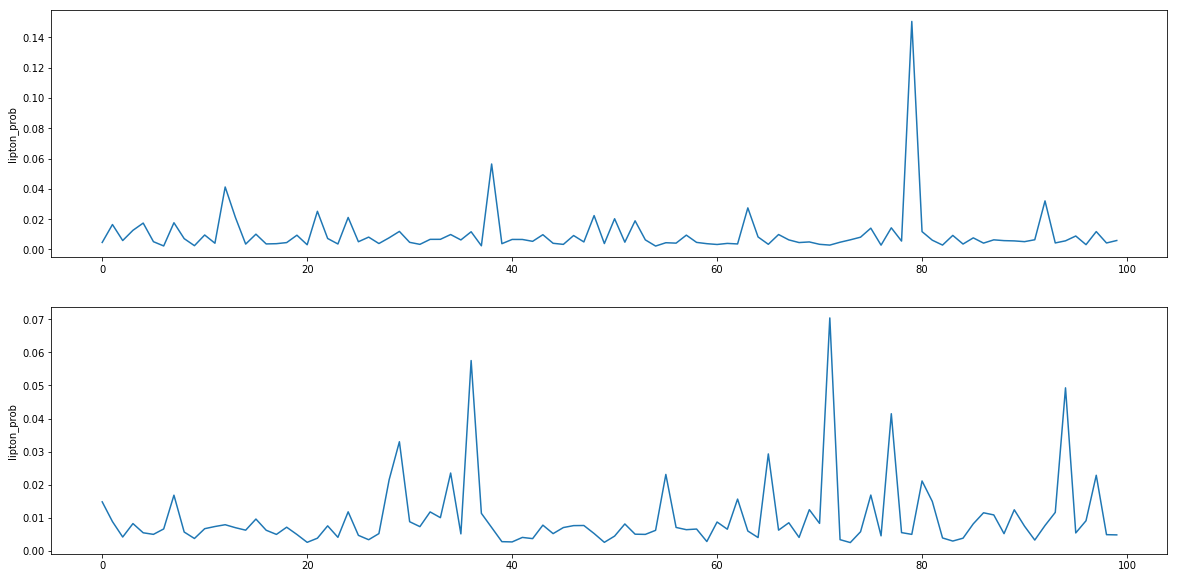

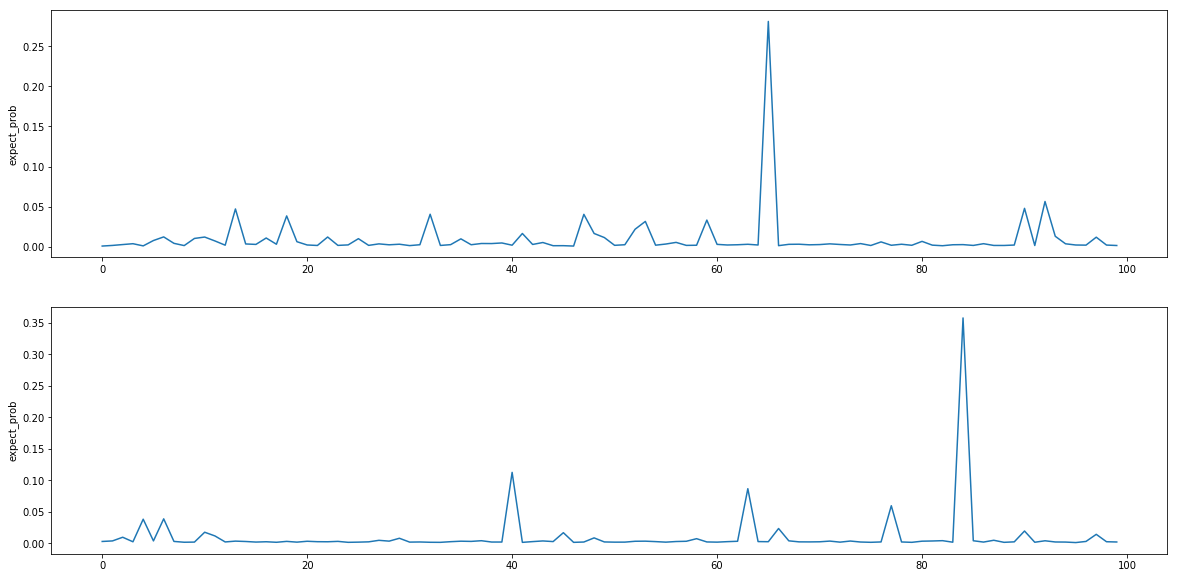

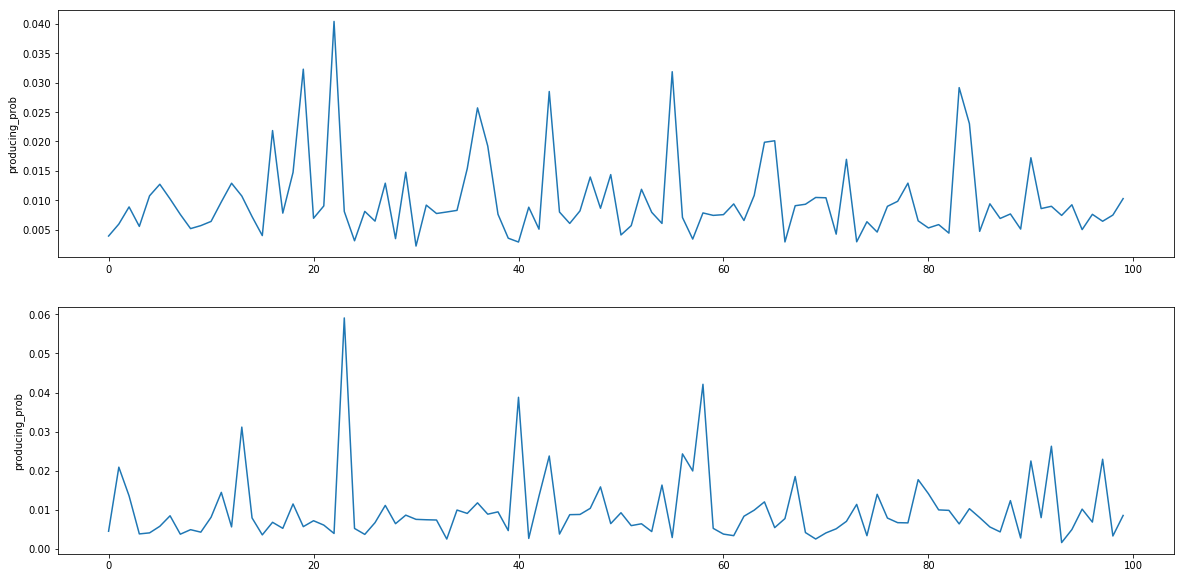

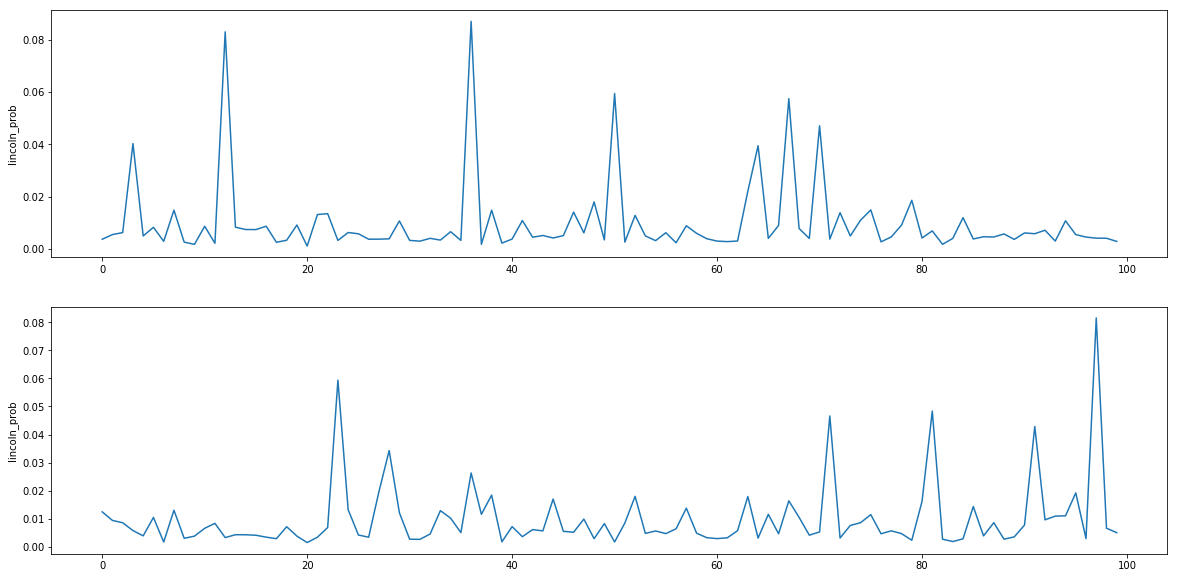

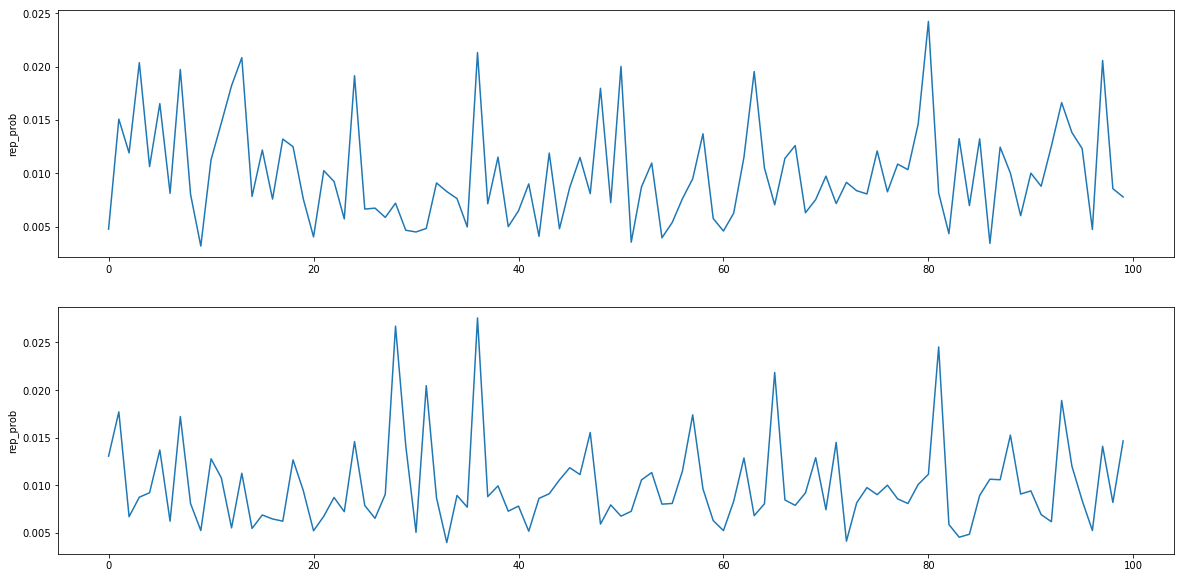

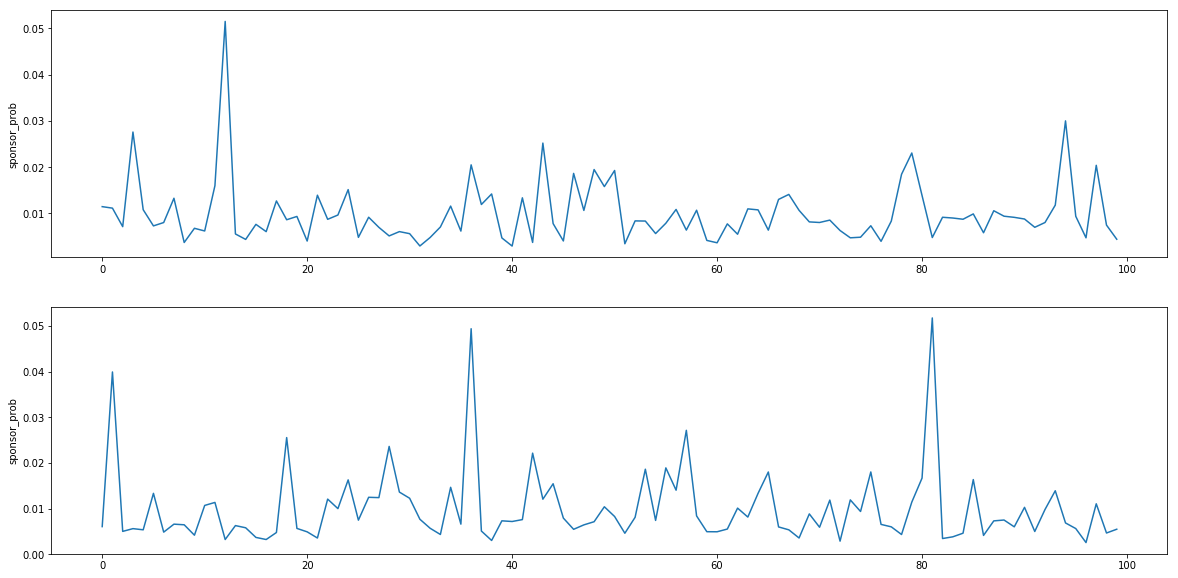

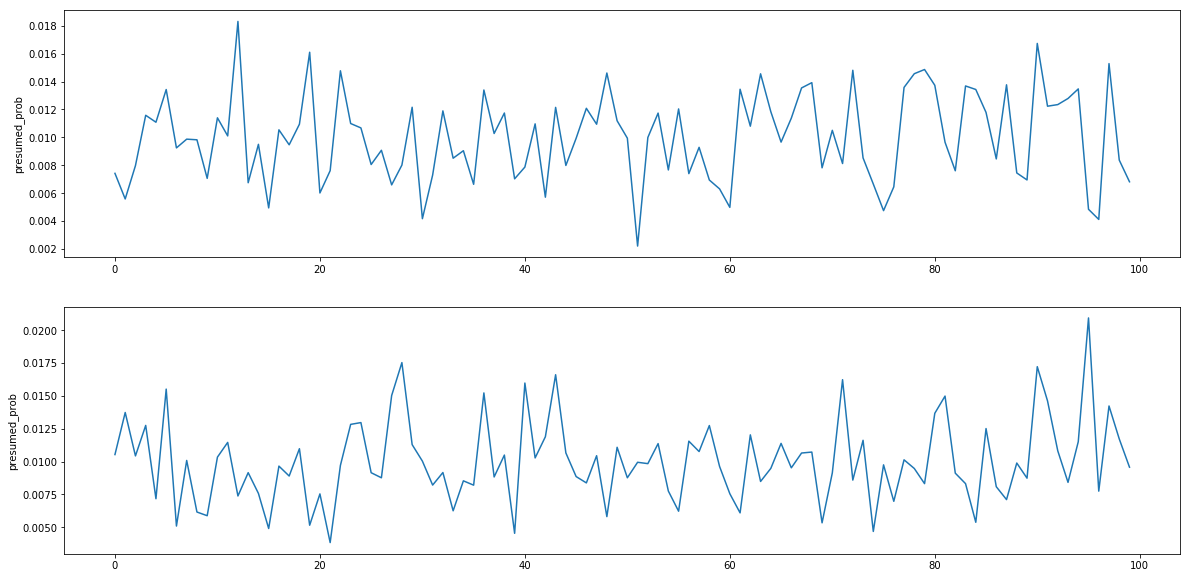

In [45]:
for i in np.random.permutation(vocab.size())[:10]:
    #print(i, vocab.decode(i))
    tf, taxarr = plt.subplots(2, 1)
    tf.set_size_inches((20,10))
    taxarr[0].plot(np_logit_prob[i][0])
    taxarr[0].set_ylabel('{}_prob'.format(vocab.decode(i)))
    taxarr[1].plot(np_logit_prob[i][1])
    taxarr[1].set_ylabel('{}_prob'.format(vocab.decode(i)))
    #print(np_logit_prob[i])
    #input()

## 6. Excel Filling

In [30]:
def visualize(filename, word_alloc, lens):
    result = np.full(lens, '', dtype=object)
    for w in word_alloc:
        result[word_alloc[w]] += ' ' + w
    pd.DataFrame(result).to_csv(filename + '.csv')

In [34]:
np_logit_emb = logit_emb.eval(sess)
np_logit_pos = np.argmax(np_logit_emb.reshape(vocab.size(), N, K), axis=2)
word_alloc = dict((vocab.decode(i), tuple(np_logit_pos[i])) for i in range(vocab.size()))
visualize('w2v_vae/vae', word_alloc, [K] * N)

## 7. Generation

In [161]:
M=100*N
np_y = np.zeros((M,K))
np_y[range(M),np.random.choice(K,M)] = 1
np_y = np.reshape(np_y,[100,N,K])

In [162]:
x_p=p_x.mean()
np_x= sess.run(x_p,{y:np_y})
# generated samples processing
np_x = np_x.argsort(axis=1)
np_x = np_x[:, -10:]
np_x_word = [vocab.decode(np_x[i].tolist()) for i in range(np_x.shape[0])]
_ = [print(s.tolist()) for s in np_x]
_ = [print(s) for s in np_x_word]

[8509, 6193, 8257, 7233, 7949, 9644, 9228, 6277, 7974, 8883]
[7050, 8054, 4986, 1568, 4238, 8569, 5094, 8920, 8103, 9223]
[8380, 9969, 4366, 7193, 9746, 6598, 9965, 8984, 6819, 9964]
[1921, 8837, 8283, 9505, 7384, 9741, 8123, 8428, 9721, 9821]
[9881, 1632, 3049, 9117, 7446, 4955, 7730, 8630, 6544, 9916]
[8492, 992, 7595, 3773, 7650, 7706, 6635, 6213, 7707, 5654]
[6700, 5774, 6734, 8823, 7857, 5802, 5891, 9950, 6840, 4605]
[8689, 4612, 8845, 6144, 7282, 3756, 9174, 8223, 3320, 9353]
[9603, 9708, 8287, 7244, 8907, 3355, 9771, 5972, 6583, 9385]
[8807, 4336, 8947, 5600, 6804, 6349, 8685, 9168, 9679, 7423]
[7460, 6543, 691, 1995, 8025, 5682, 9249, 4350, 9958, 9957]
[8156, 5914, 5553, 9147, 5028, 4329, 8154, 7135, 7569, 8912]
[7883, 546, 9279, 5942, 9247, 8184, 3853, 5479, 6758, 6378]
[9295, 8780, 7781, 7852, 7811, 8210, 9543, 8876, 7879, 7423]
[7898, 6609, 6819, 7292, 9284, 6547, 510, 9125, 8942, 9784]
[3996, 7424, 7433, 8919, 3521, 1686, 373, 6627, 4293, 2314]
[2931, 3387, 9775, 6052, 9607

## 8. Visualize the Embedding

In [ ]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.show()
    
# Plot
final_embeddings = sess.run(normalized_emb)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = np.random.permutation(vocab.size())[:500]
low_dim_embs = tsne.fit_transform(final_embeddings[plot_only])
labels = [vocab.decode(i) for i in plot_only]
plot_with_labels(low_dim_embs, labels)